# 1. Lendo bibliotecas

In [1]:
import numpy as np
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
import pandas as pd
import os

# 2. Ler o DataSet

In [10]:
filename = 'dataset.xlsx'
if not filename in os.listdir():
    print(f'Não encontrei o arquivo {filename}')

In [11]:
dados = pd.read_excel(filename)

# 3. Limpar o DataSet

In [12]:
# Remover a coluna "categoria"
dados = dados.drop('category', 1)

print(f"Temos as colunas {dados.columns}")

Temos as colunas Index(['price (£)', 'number_of_reviews', 'rating'], dtype='object')


/var/folders/gj/1r66hhws0pxggh3y_j668sfr0000gn/T/ipykernel_35215/1131593697.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  dados = dados.drop('category', 1)


# 4. Análise Exploratória

In [5]:
print(dados.describe(include = 'all'))

         price (£)  number_of_reviews       rating
count  7986.000000        7986.000000  7986.000000
mean     19.848063           9.371776     4.709154
std      39.049344          36.484311     0.372529
min       0.010000           1.000000     2.300000
25%       4.630000           1.000000     4.500000
50%      10.000000           2.000000     5.000000
75%      19.990000           6.000000     5.000000
max     995.110000        1399.000000     5.000000


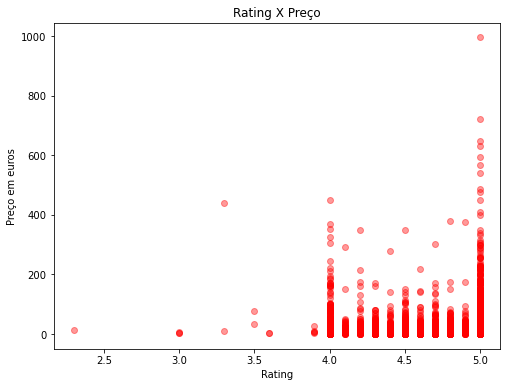

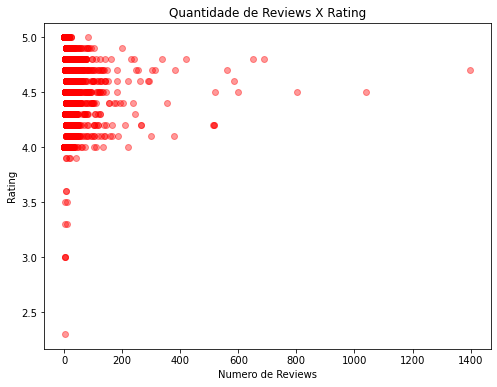

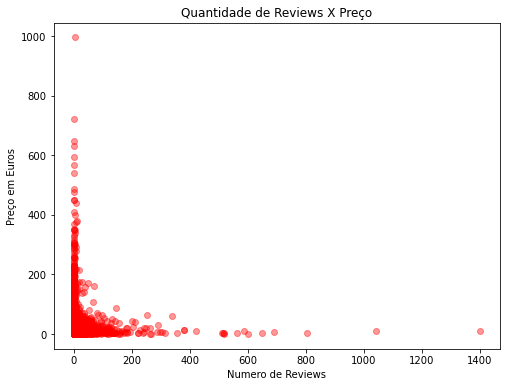

In [6]:

plt.figure(figsize = (8,6))
plt.scatter(dados.rating,dados["price (£)"], c='red', alpha=0.4)
plt.title('Rating X Preço')
plt.xlabel('Rating')
plt.ylabel('Preço em euros')
plt.show()

plt.figure(figsize = (8,6))
plt.scatter(dados.number_of_reviews, dados.rating, c='red', alpha=0.4)
plt.title('Quantidade de Reviews X Rating')
plt.xlabel('Numero de Reviews')
plt.ylabel('Rating')

plt.show()

plt.figure(figsize = (8,6))
plt.scatter(dados.number_of_reviews, dados["price (£)"], c='red', alpha=0.4)
plt.title('Quantidade de Reviews X Preço')
plt.xlabel('Numero de Reviews')
plt.ylabel('Preço em Euros')

plt.show()


## 5. Começando o Algorítimo
Neste passo vamos fazer uma regressão linear multivariada, levando em consideração a avaliação em função do preço e número de reviews.